Authors: Giorgi Butbaia (Giorgi.Butbaia@unh.edu) & Elli Heyes (elli.heyes@city.ac.uk)
Last edited: 11/06/2024

In this notebook we construct a reinforcement learning algorithm to generate FRST triangulations of reflexive polytopes together with 3d reflexive subpolytopes that describe K3 fibrations of the CY.
We use a deep Q-learning algorithm, where the triangulation states are encoded by 2-face triangulations. 

In [1]:
import sys
import subprocess
try:
    import keras 
    import tensorflow as tf
    tfk = tf.keras
except:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tensorflow'])
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'keras'])
    import keras
    import tensorflow as tf
    tfk = tf.keras
try:
    import mplhep as hep
except:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'mplhep'])
    import mplhep as hep 
import random
import numpy as np
import matplotlib.pyplot as plt
from agent import Agent
from tqdm import trange
from copy import copy, deepcopy
from collections import deque
from cytools import Polytope, fetch_polytopes
from utils import get_two_face_triangs, get_T_actions, random_T_state, T_fitness, T_act, flatten_T_state, restore_T_state

2024-06-11 11:24:21.897138: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 11:24:21.904247: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 11:24:22.139353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 11:24:24.229140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class TriangulationEnvironment(object):
    def __init__(self, polytope):
        self._poly = polytope
        self._2face_Ts = self.get_two_face_triangs(polytope)
        self._max_num_triangs = max(len(x) for x in self._2face_Ts)
    
    def random_state(self):
        """ 
        Output: random 2d bitlist state describing two-face triangulations   
        """
        return random_T_state(self._2face_Ts, self._max_num_triangs)
    
    def act(self, state, action):
        """
        Input: state-action pair
        Output: new state obtained by acting on the old state with the action 
        """
        return T_act(state, action)
    
    def get_actions(self):
        """
        Output: the list of all possible actions on the triangulation state
        """
        return get_T_actions(self._2face_Ts)
    
    def fitness(self, state):
        """
        Input: state describing triangulation state
        Output: the fitness value between 0 and 1 for the state 
        """
        return T_fitness(self._poly, self._2face_Ts, state)

    @property
    def two_face_triangs(self):
        return self._2face_Ts

    @staticmethod
    def get_two_face_triangs(poly):
        """
        Input: polyotpe
        Output: 2d list of all inequivalent 2-face triangulations
        """
        return get_two_face_triangs(poly)
        

In [12]:
class QNet(tfk.Model):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self._dense1 = tfk.layers.Dense(64, activation='relu', input_shape = input_shape)
        self._dense2 = tfk.layers.Dense(128, activation='relu')
        self._dense3 = tfk.layers.Dense(output_shape, activation='linear')
        self.output_shape = [output_shape]

    def call(self, x):
        x = self._dense1(x)
        x = self._dense2(x)
        x = self._dense3(x)
        return x

In [20]:
# define the polytope
all_polys = fetch_polytopes(h11=15, lattice="N", as_list=True, limit=100)
p = all_polys[0]

# initialise the triangulation environment
T_env = TriangulationEnvironment(p)

# get the model dimensions
state = T_env.random_state()
state_shape = np.array(state).flatten().shape

actions = T_env.get_actions()
action_shape = len(actions)

# define the RL agent
buffer_size = 2**11

model = QNet(input_shape=state_shape, output_shape=action_shape)
model.compile(
    loss = tfk.losses.MeanSquaredError(),
    optimizer = tfk.optimizers.Adam(learning_rate =1e-3),
    metrics = [tfk.metrics.MeanAbsoluteError()])

target_model  = QNet(input_shape=state_shape, output_shape=action_shape)
target_model.compile(
    loss = tfk.losses.MeanSquaredError(),
    optimizer = tfk.optimizers.Adam(learning_rate =1e-3),
    metrics = [tfk.metrics.MeanAbsoluteError()])
target_model.set_weights(model.get_weights())

agent = Agent(model=model, target_model=target_model, buffer_size=buffer_size)

In [22]:
# pre training test
pre_steps, pre_count, terminal_states = [], [], []
finished = False
while not finished:
    # initialise state
    state = T_env.random_state()
    num_steps = 0
    
    # check if initial state is aleady terminal
    fitness = T_env.fitness(state)
    if fitness == 1:
        done = True
        pre_steps.append(num_steps)
        
        # if terminal state not in list then add it 
        if not state in terminal_states:
            terminal_states.append(state)
        
        # if no new states are found in the last 1000 runs then finish
        pre_count.append(len(terminal_states))
        if len(pre_count) > 1000:
            if len(set(pre_count[-1000:])) == 1:
                finished = True
    else:
        done = False
    
    state = flatten_T_state(state)
    while not done:
        # get action and new state
        action = agent.act(state)
        new_state = T_env.act(restore_T_state(state, T_env._max_num_triangs), actions[action])
        
        # check if new state is terminal
        fitness = T_env.fitness(new_state)
        if fitness == 1:
            done = True
            pre_steps.append(num_steps)
            
            # if terminal state not in list then add it 
            state_restore = [list(x) for x in restore_T_state(state, T_env._max_num_triangs)]
            if not state_restore in terminal_states:
                terminal_states.append(state_restore)
            
            # if no new states are found in the last 1000 runs then finish
            pre_count.append(len(terminal_states))
            if len(pre_count) > 1000:
                if len(set(pre_count[-1000:])) == 1:
                    finished = True
            
        state = flatten_T_state(new_state)
        num_steps += 1
    
print("Av # steps pre training:", np.mean(pre_steps))

Av # steps pre training: 0.03847328244274809


In [27]:
# set parameters
batch_size = 256
MAX_ITER = 32
MIN_MEMORY_SIZE = 1024

# train RL model 
loss_vals = []
steps_to_update_target_model = 0
with trange(1024) as t_epochs:
    for epoch in t_epochs:
        # get initial random state
        state = T_env.random_state()
        fitness = T_env.fitness(state)
        state = flatten_T_state(state)
        
        # continue until terminated 
        terminated = False
        total_loss = 0.0
        count = 0
        for i in range(MAX_ITER):
            steps_to_update_target_model += 1
            
            # get action and obtain new state 
            action = agent.act(state)
            new_state = T_env.act(restore_T_state(state, T_env._max_num_triangs), actions[action])
            new_fitness = T_env.fitness(new_state)
            new_state = flatten_T_state(new_state)
            
            # compute reward
            reward = 0.
            if new_fitness == 1:
                reward = 10.
                terminated = True
            else:
                reward = new_fitness - fitness
            
            # update history
            agent.store(state, action, reward, new_state, terminated)

            if terminated or (steps_to_update_target_model % 4 == 0):
                if agent.current_memory_size > MIN_MEMORY_SIZE:
                    history = agent.replay(batch_size)
                    total_loss += history.history['loss'][-1]
                    count += 1

            # update state
            state = deepcopy(new_state)
            fitness = copy(new_fitness)

            if terminated:
                if steps_to_update_target_model >= 100:
                    agent.update_target_model()
                    steps_to_update_target_model = 0

            if terminated:
                break
                
        t_epochs.set_description(f"Loss: {total_loss / (count+1e-10)}")
        loss_vals.append(total_loss / (count+1e-10))

Loss: 0.00031474477142673406: 100%|█████████████████████████████████████████████████████████████| 1024/1024 [06:21<00:00,  2.69it/s]


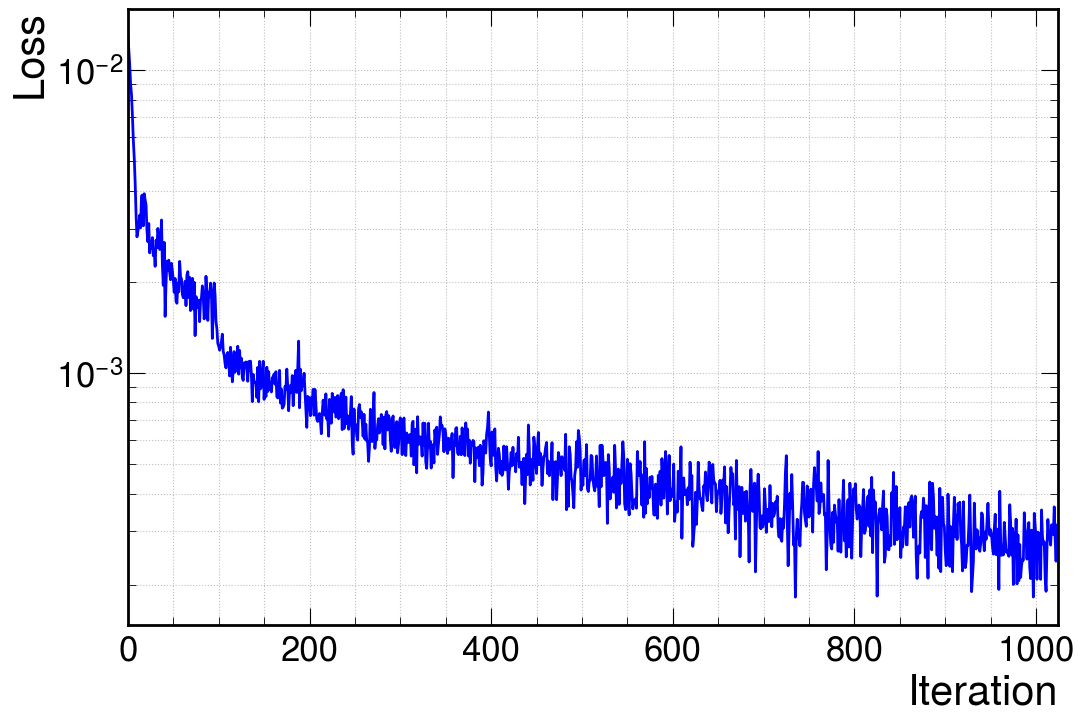

In [28]:
# plot loss curve
hep.style.use("CMS")
plt.rcParams.update({
    "text.usetex": False, # LaTeX not available in cytools env
    'font.size': 30
})
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(loss_vals, 'b-', label="Loss", linewidth=2)
x0 = min(x for x in range(len(loss_vals)) if loss_vals[x]!=0)
ax.set_xlim([x0, len(loss_vals)]) # start when ~MIN_MEMORY_SIZE is reached
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid(True, 'both')

In [29]:
# post training test
post_steps, post_count, terminal_states = [], [], []
finished = False
while not finished:
    # initialise state
    state = T_env.random_state()
    num_steps = 0
    
    # check if initial state is aleady terminal
    fitness = T_env.fitness(state)
    if fitness == 1:
        done = True
        post_steps.append(num_steps)
        
        # if terminal state not in list then add it 
        if not state in terminal_states:
            terminal_states.append(state)
        
        # if no new states are found in the last 1000 runs then finish
        post_count.append(len(terminal_states))
        if len(post_count) > 1000:
            if len(set(post_count[-1000:])) == 1:
                finished = True
    else:
        done = False
    
    state = flatten_T_state(state)
    while not done:
        # get action and new state
        action = agent.act(state)
        new_state = T_env.act(restore_T_state(state, T_env._max_num_triangs), actions[action])
        
        # check if new state is terminal
        fitness = T_env.fitness(new_state)
        if fitness == 1:
            done = True
            post_steps.append(num_steps)
            
            # if terminal state not in list then add it 
            state_restore = [list(x) for x in restore_T_state(state, T_env._max_num_triangs)]
            if not state_restore in terminal_states:
                terminal_states.append(state_restore)
            
            # if no new states are found in the last 1000 runs then finish
            post_count.append(len(terminal_states))
            if len(post_count) > 1000:
                if len(set(post_count[-1000:])) == 1:
                    finished = True
            
        state = flatten_T_state(new_state)
        num_steps += 1
    
print("Av # steps post training:", np.mean(post_steps))

Av # steps post training: 0.0002242152466367713


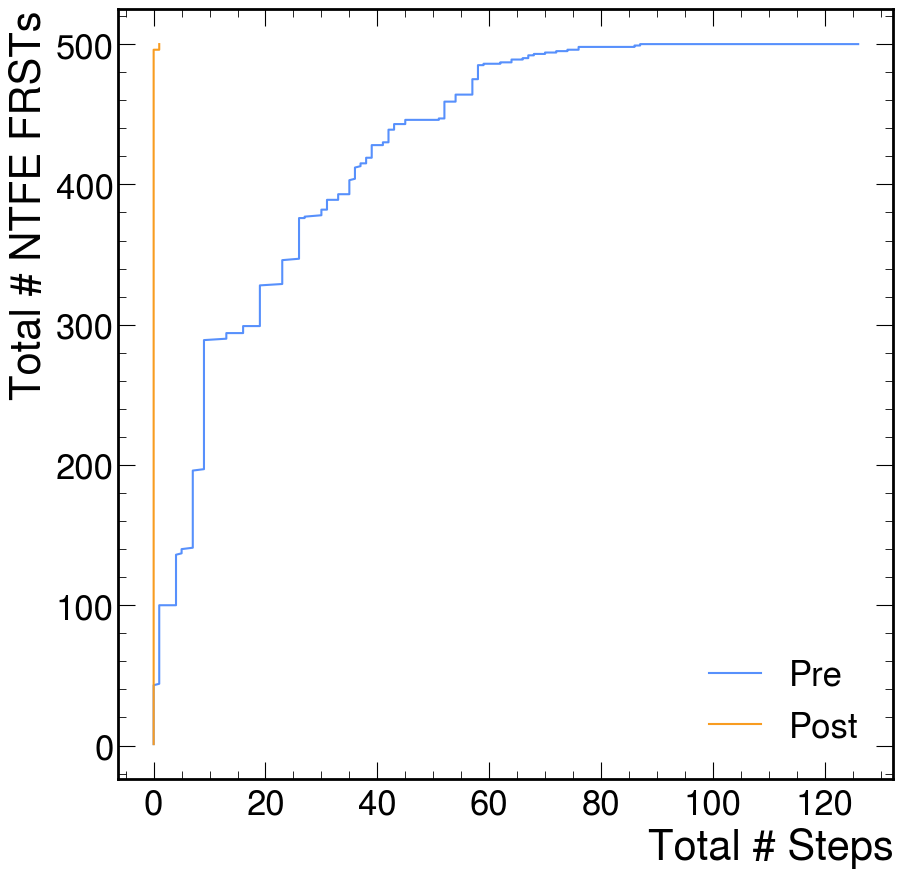

In [30]:
pre_total_steps = [pre_steps[0]]
for i in range(1,len(pre_steps)):
    pre_total_steps.append(pre_total_steps[i-1]+pre_steps[i])

post_total_steps = [post_steps[0]]
for i in range(1,len(post_steps)):
    post_total_steps.append(post_total_steps[i-1]+post_steps[i])
    
plt.plot(pre_total_steps, pre_count, label="Pre")
plt.plot(post_total_steps, post_count, label="Post")
plt.xlabel('Total # Steps')
plt.ylabel('Total # NTFE FRSTs')
plt.legend()
plt.savefig('Example_FRST')